# generate lists of words to explain the clusters

### Jan 9 2020, Brendan Chambers

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

import hdbscan
import umap

import time
import random
import re

import spacy
from gensim.models import Word2Vec

from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus


### load in word2vec models trained on each coarse cluster

In [2]:
# temp, recreate the list of file names without re-training the w2v models

model_names = ['data_processing/cluster0.model',
        'data_processing/cluster1.model',
        'data_processing/cluster2.model']
print(model_names)
print()

models = {}
for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    print(short_name)
    
    model = Word2Vec.load(model_name)
    models[short_name] = model
    print('{} words '.format(len(model.wv.vocab)))  # length of the vocab dict
    print()
    
#  ~16,000 words across all 3 clusters (> 25 times)
#  ~3,000 words occurring in all 3 clusters (> 25 times)
#  window size 15

['data_processing/cluster0.model', 'data_processing/cluster1.model', 'data_processing/cluster2.model']

cluster0.model
9738 words 

cluster1.model
5275 words 

cluster2.model
10261 words 



In [3]:
# build a networkx graph for each word similarity network

number of dimensions D: 25
(9738, 9738)
plotting subset of weights: 
number of dimensions D: 25
(5275, 5275)
plotting subset of weights: 
number of dimensions D: 25
(10261, 10261)
plotting subset of weights: 


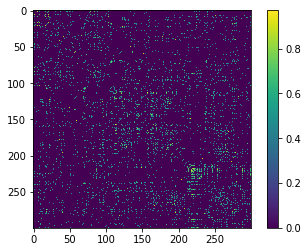

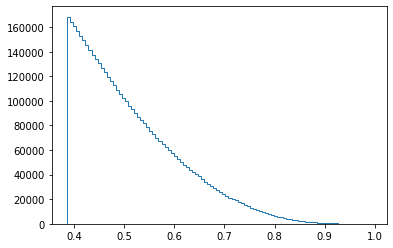

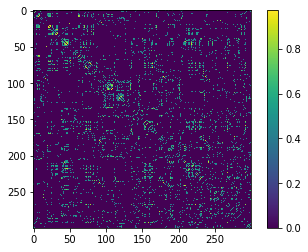

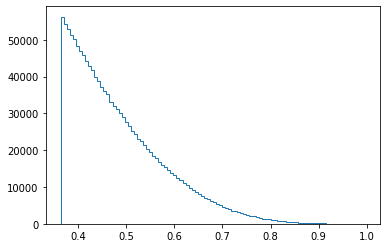

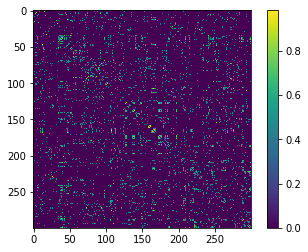

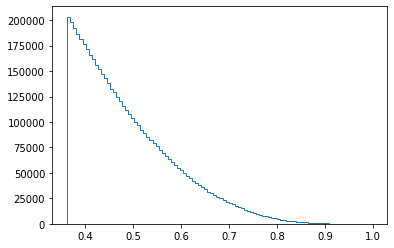

In [4]:
# todo use unique vocabularies for starters

# todo match vocabulary sizes


nx_graphs = []
for idx, model in enumerate(models.values()):
    
    # the number of nodes is small so we can do this with naive mat mul, nothing clever needed
    
    D = np.shape(model.wv['data'])[0] # dimensionality of a sample word, any word will do
    print("number of dimensions D: {}".format(D))
    
    embedding_samples = np.zeros( (len(model.wv.vocab), D) )
    
    # collect samples
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] = model.wv[word]
        
    # reduce dimensionality
    #D_umap = 5
    #reducer = umap.UMAP(n_components=D_umap)
    #um = reducer.fit_transform(embedding_samples)    # concatenated
    #embedding_samples = um
    
    # demean
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
        
    # compute cosine similarity (projection of normalized vectors)
    W = np.matmul(embedding_samples, embedding_samples.T)
    np.fill_diagonal(W, 0)  # no self-loops
    #thresh_low = np.percentile(W.flatten(), 0)  # probably shouldn't do this
    thresh_high = np.percentile(W.flatten(), 90)
    #boolean_mask = np.logical_and(W < thresh_high, W > thresh_low)
    boolean_mask = W < thresh_high
    W[boolean_mask] = 0 # mask out some weights for testing
    print(np.shape(W))
    
    print("plotting subset of weights: ")
    plt.figure()
    plt.imshow(W[:300,:300])
    plt.colorbar()
    
    plt.figure()
    plt.hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),histtype='step', bins=100)
    
    #W_binary = (W > 0).tolist()
    #ggg[idx] = igraph.Graph.Adjacency(W_binary)  # define connections
    #ggg[idx].es['weight'] = W[W.nonzero()]
    #G_igraph = igraph.Graph.Weighted_Adjacency(W.tolist(),
    #                                           mode=igraph.ADJ_UNDIRECTED,
    #                                          loops=False,
    #                                          attr='weight')
    #igraphs.append(G_igraph)
    
    # create networkx version
    G_nx = nx.from_numpy_matrix(W)  # create using - 
    nx.set_node_attributes(G_nx,
                           dict((i,w) for i,w in enumerate(model.wv.vocab)),
                           'word')
    d_eigcent = nx.eigenvector_centrality(G_nx, max_iter=200)
    nx.set_node_attributes(G_nx, d_eigcent, 'eigenvector_centrality')
    nx_graphs.append(G_nx)
    

computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.


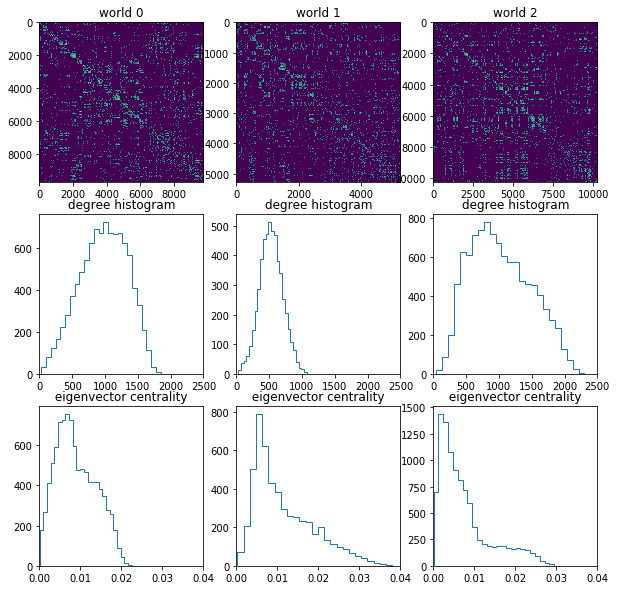

In [5]:
# plot the adjmats

(f, ax) = plt.subplots(3,
                       3,
                       figsize=(10,10))

community_results = []
for idx, G in enumerate(nx_graphs):
    
    print('computing num triangles...')
    #communities = nx.algorithms.community.label_propagation_communities(G)
    #community_results.append([x for x in communities])
    
    print('fetching adjmat...')
    W = nx.convert_matrix.to_numpy_matrix(G)
    print('computing cuthull mckee ordering...')
    rcm = list(nx.utils.cuthill_mckee_ordering(G)) # pick the smallest to define the ordering
    print('finished.')

    W = nx.convert_matrix.to_numpy_matrix(G, nodelist=rcm)
    ax[0,idx].imshow(W, aspect='auto', cmap='magma')
    ax[0,idx].set_title('world {} in order #{}'.format(idx, idx))
    
    degrees = [d for n,d in G.degree()]
    
    ax[0,idx].imshow(W,aspect='auto')
    ax[0,idx].set_title('world {}'.format(idx))
    
    #ax[1,idx].set_ylim(bottom=0)
    ax[1,idx].hist(degrees, bins=25, histtype='step')
    ax[1,idx].set_title('degree histogram')
    ax[1,idx].set_xlim([0,2500])
    
    '''
    d_triangles = nx.get_node_attributes(G,'triangles')
    ax[2,idx].hist([count for count in d_triangles.values()], bins=25, histtype='step')
    ax[2,idx].set_title('triangles histogram')
    ax[2,idx].set_xlim([0,80000])
    '''
    
    d_eigcent = nx.get_node_attributes(G, 'eigenvector_centrality')
    ax[2,idx].hist([count for count in d_eigcent.values()], bins=25, histtype='step')
    ax[2,idx].set_title(' eigenvector centrality ')
    ax[2,idx].set_xlim([0,0.04])
    
#plt.savefig('network_worlds_overview.http://128.135.250.219:8888/notebooks/research_dynamics/dynamics_v2/explain_clusters.ipynb#pdf')
#plt.savefig('network_worlds_overview.png')

computing cuthull mckee ordering...
finished.
computing cuthull mckee ordering...
finished.
computing cuthull mckee ordering...
finished.


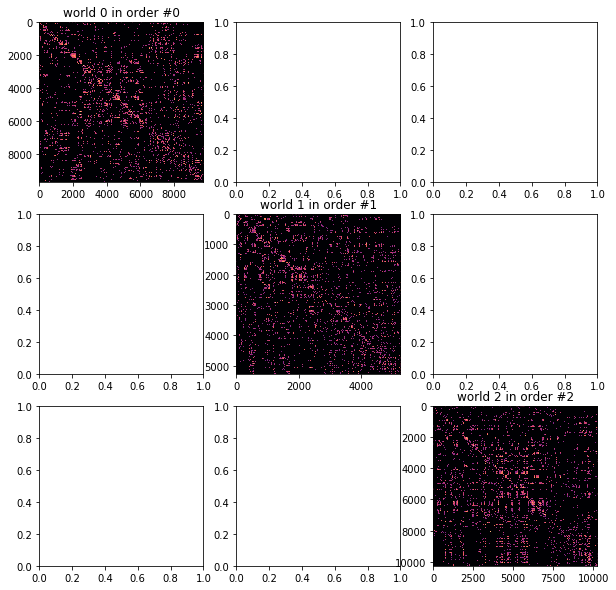

In [6]:
# plot each adjmat in cuthill-mckee order

# todo orient the overview plot horizontally instead (mimicking the plot above)


(f, ax) = plt.subplots(3,
                       3,
                       figsize=(10,10))

for reference_id in range(3):
    
    print('computing cuthull mckee ordering...')
    rcm = list(nx.utils.cuthill_mckee_ordering(nx_graphs[reference_id])) # pick the smallest to define the ordering
    print('finished.')

    W = nx.convert_matrix.to_numpy_matrix(nx_graphs[reference_id], nodelist=rcm)
    ax[reference_id,reference_id].imshow(W, aspect='auto', cmap='magma')
    ax[reference_id,reference_id].set_title('world {} in order #{}'.format(reference_id, reference_id))

#plt.savefig('cuthill_mckee.pdf')
#plt.savefig('cuthill_mckee.png')
    

In [7]:
# compare source and target cluster anchor words

In [8]:
# perhaps try this to compare two semantic networks in the future:

#source_cluster_id = 0
#target_cluster_id = 1

# anchor words for cluster 0
# anchor words for cluster 1

# most similar anchor words / semantic network backbone

# most dissimilar semantic network 



In [9]:
def plot_eigcent_nodes(cluster_id):
    
    d_eigcent = nx.get_node_attributes(nx_graphs[cluster_id],'eigenvector_centrality')
    d_words = nx.get_node_attributes(nx_graphs[cluster_id], 'word')

    # sort ascending
    top_nodes = [t[0] for t in sorted(d_eigcent.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_eigcent.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]

    top_words = [d_words[i] for i in top_nodes]  # idxs -> words

    # print
    K = int(np.floor(0.005 * len(scores)))
    print(top_words[:K])

    plt.figure()
    plt.plot(scores[:K],color='r')
    plt.plot(scores, color=[0,0,0,0.25], linestyle=':')
    

    node_subset = top_nodes[:K]
    G = nx_graphs[cluster_id].subgraph(node_subset)
    
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    #print(weights)

    d_eigcent = nx.get_node_attributes(nx_graphs[cluster_id],'eigenvector_centrality')

    labels = dict( (node,top_words[i]) for i,node in enumerate(G.nodes()))
    
    d_layout_full = nx.spring_layout(nx_graphs[cluster_id].subgraph(top_nodes[:2000]))  # TEMP cutoff for prototyping
    d_layout = {k: d_layout_full[k] for k in top_nodes[:K]}

    SCALE = 10000
    node_sizes = SCALE*np.array([f for f in scores])
    
    plt.figure()
    nx.draw(G,
           pos=d_layout, # s[idx],  #d_layout
           with_labels=False,
           node_color=[[0.1,0.3,0.2,0.1]],
           node_size=node_sizes, #  labels=labels,
           edgelist=edges,
           edge_color=weights,
           width=0.25,
           edge_cmap=plt.cm.Blues) 

['ectoparasites', 'farmed', 'legionella', 'grapevine', 'indigenous', 'japonica', 'trout', 'bee', 'rainbow', 'cysts', 'turtles', 'lepidoptera', 'flora', 'wild', 'grass', 'bird', 'nematode', 'crabs', 'diptera', 'farming', 'breed', 'dung', 'cabbage', 'domesticated', 'african', 'amphibian', 'resident', 'carnivores', 'mites', 'buffaloes', 'ternary', 'cultivated', 'pnipam', 'snail', 'initiator', 'rabies', 'hemiptera', 'poultry', 'pani', 'salmon', 'asian', 'bromide', 'nematodes', 'oysters', 'migratory', 'poland', 'ducks', 'dairy']


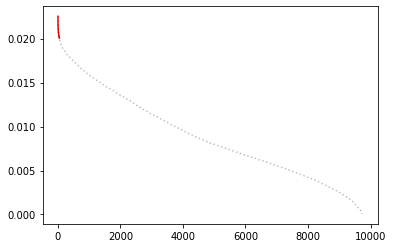

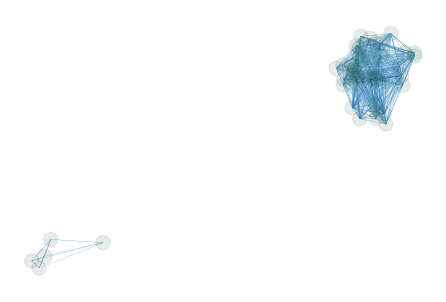

In [10]:
cluster_id = 0
plot_eigcent_nodes(cluster_id)

['problems', 'concern', 'transplant', 'care', 'arise', 'becoming', 'platforms', 'replacement', 'organ', 'widespread', 'organs', 'limitations', 'ongoing', 'scale', 'general', 'extend', 'transplants', 'researchers', 'artificial', 'efforts', 'engineering', 'challenges', 'allowing', 'intensive', 'individual', 'developing']


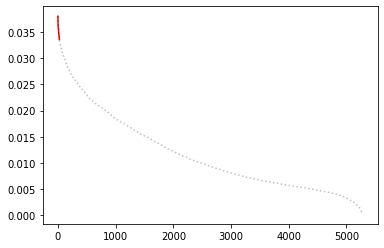

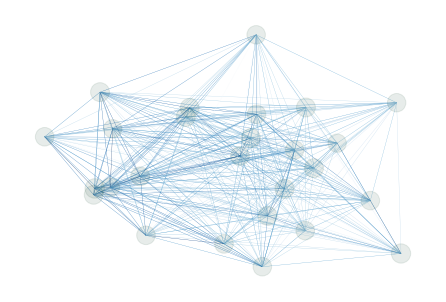

In [11]:
cluster_id = 1
plot_eigcent_nodes(cluster_id)

['fibrin', 'infiltration', 'inferior', 'enlargement', 'toe', 'cava', 'edema', 'vena', 'synovial', 'veins', 'mucosal', 'mesenteric', 'enlarged', 'superficial', 'vein', 'lumen', 'lysis', 'calcified', 'capsule', 'ica', 'dilated', 'thickening', 'vessel', 'dilatation', 'compartment', 'junction', 'effusion', 'outflow', 'alveolar', 'bronchial', 'sinus', 'popliteal', 'splenic', 'extracranial', 'accessory', 'deep', 'contralateral', 'scintigraphy', 'intravascular', 'aorta', 'dilation', 'macroscopic', 'collaterals', 'dural', 'cerebrospinal', 'bifurcation', 'pleural', 'parenchymal', 'occlusive', 'gallbladder', 'diaphragm']


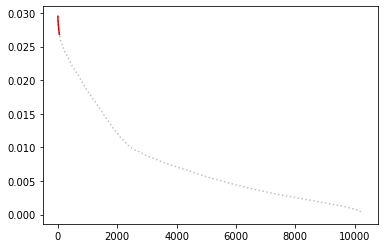

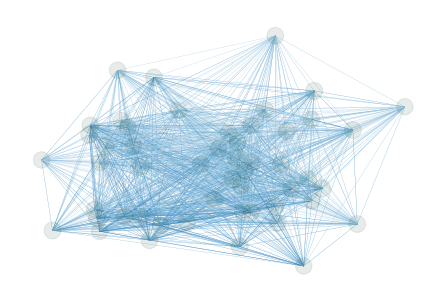

In [12]:
cluster_id = 2
plot_eigcent_nodes(cluster_id)
